In [70]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from scipy.stats import randint
from scipy.stats import uniform

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV


pd.set_option('display.max_columns', None)

In [4]:
x_train_init = pd.read_csv("~/Downloads/big_test_data/train.csv")
x_test = pd.read_csv("~/Downloads/big_test_data/test.csv")
y_train_init = pd.read_csv("~/Downloads/big_test_data/y_train.csv")

In [68]:
def detect_int(data):
    ## pandas column - input
    ## output - name of that column if all unique values match the int pattern
    data_filtered = data.dropna()
    data_filtered_unique_strings = data_filtered.astype(str).unique()
    data_filtered_all_ints = pd.Series(data_filtered_unique_strings).str.match('^\d+\.[0]+$').all()
    if data_filtered_all_ints:
        return data.name
    

def grid_scores_to_df(grid_scores):
    """
    Convert a sklearn.grid_search.GridSearchCV.grid_scores_ attribute to a tidy
    pandas DataFrame where each row is a hyperparameter-fold combinatination.
    """
    rows = list()
    for grid_score in grid_scores:
        for fold, score in enumerate(grid_score.cv_validation_scores):
            row = grid_score.parameters.copy()
            row['fold'] = fold
            row['score'] = score
            rows.append(row)
    df = pd.DataFrame(rows)
    return df

In [6]:
# x_train.describe()

Столбцы - смешанной locale, используют как "," так и "." для делимитации

Конвертируем в единообразную систему с "." для удобства самым простым способом - regex.

In [7]:
x_train_init.loc[:,x_train_init.select_dtypes(include=['object']).columns.tolist()] =\
                    x_train_init.loc[:,x_train_init.select_dtypes(include=['object']).columns.tolist()].\
                    replace(to_replace=',', value='.', regex=True)

x_test.loc[:,x_test.select_dtypes(include=['object']).columns.tolist()] =\
                    x_test.loc[:,x_test.select_dtypes(include=['object']).columns.tolist()].\
                    replace(to_replace=',', value='.', regex=True)

In [8]:
# Конвертируем все значения в float для последующ

In [9]:
# x_train = x_train.astype("float32")

Создаем dict с маппингом столбцов и int64 для последующей конвертации dtype

Также создаем list для выбора столбцов - т.к. столбцы похожи на качественные переменные и перед тем как конвертировать их нам необходимо понять будет ли к ним применен OneHotEncode или следует оставить их как количественные переменные.

In [10]:
columns_to_int = {i : "int64" for i in x_train_init.apply(detect_int, axis = 0) if i is not None}

In [11]:
columns_int_list = [i for i in columns_to_int.keys()]

Допустим, переменные, не содержащие 0 - количественные, потому что LabelEncoder начинает с 0. Ниже - частота значений столбцов int и список уникальных значений.

Распределение некоторых значений напоминает нормальное распределение, другие распределения похожи на Poisson, остальные либо похожи на распределения качественных переменных, либо явно содержат уникальные значения [0, 1] - явный знак бинарных переменных.

Т.к. в производственной среде мы имеем точное знание о переменных и методе их формирования и нет необходимости определять тип переменной - мы допустим, что int переменные, содержащие 0 как минимальное значение - закодированные качественные переменные. Дополнительное доказательство - наличие NaN значений - в некоторых случаях количественные переменные и качественные дублируются, к примеру "клиент оставил отзыв" и "количество оставленных отзывов" - в данном случае вероятность того, что количество отзывов может быть 0 и наличие NaN в одной переменной не имеют логического значения - их существование взаимно исключает друг друга.

Т.к. переменные изначально неинтерпретируемы - мы не теряем информации, если используем OneHotEncode на эти переменные и уменьшим размерность таблицы качественных значений используя SVD.

Это допущение также упрощает стратегию Imputation для NaN - мы можем использовать искуственную категорию 999 которая будет означать "данные отсутствуют" чтобы избежать допущения, что данные равны медиане или наиболее/наименее частому значению.

In [12]:
for i in columns_int_list:
    train_distrib_cat = x_train_init.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").\
                                        value_counts().\
                                        sort_index()
    train_distrib_cat_vals = x_train_init.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").\
                                        value_counts().\
                                        index.tolist()
    
    test_distrib_cat_vals = x_test.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").\
                                        value_counts().\
                                        index.tolist()
    
    if 0 in train_distrib_cat_vals:
        print(train_distrib_cat)
        print("Values sorted:")
        print(sorted(train_distrib_cat_vals))
        print("Values test:")
        print(sorted(test_distrib_cat_vals))
        print("Nulls as % of shape:")
        print('{:.3f}'.format(x_train_init.loc[:,i].isnull().sum() / x_train_init.shape[0]))
        print("\n")

0    472718
1    161043
2     20521
3      1140
4        16
Name: feature_5, dtype: int64
Values sorted:
[0, 1, 2, 3, 4]
Values test:
[0, 1, 2, 3, 4]
Nulls as % of shape:
0.090


0     12841
1    103081
2    276905
3    244561
Name: feature_6, dtype: int64
Values sorted:
[0, 1, 2, 3]
Values test:
[0, 1, 2, 3]
Nulls as % of shape:
0.115


0    464111
1    171081
Name: feature_10, dtype: int64
Values sorted:
[0, 1]
Values test:
[0, 1]
Nulls as % of shape:
0.118


0      15105
1      65859
2     132135
3     162143
4     135938
5      82316
6      36664
7      12329
8       3080
9        555
10        81
11         5
12         4
Name: feature_18, dtype: int64
Values sorted:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Values test:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]
Nulls as % of shape:
0.102


0      11637
1      47269
2      94535
3     126174
4     125598
5     100268
6      66563
7      38040
8      19247
9       8715
10      3380
11      1258
12       383
13       131
14        46


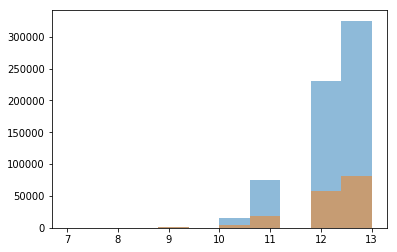

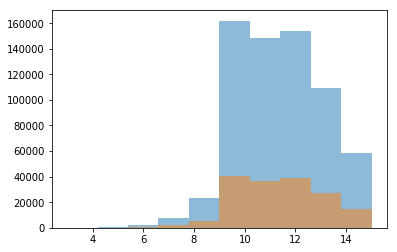

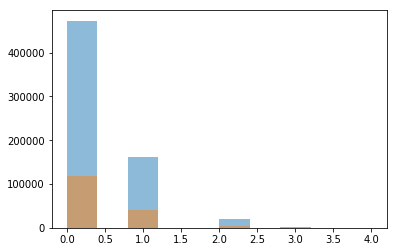

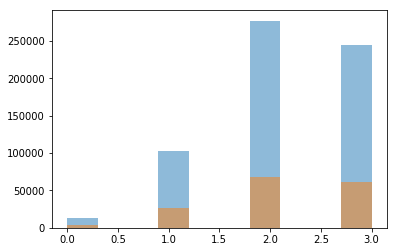

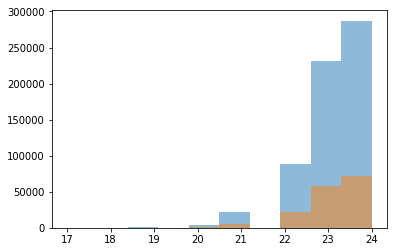

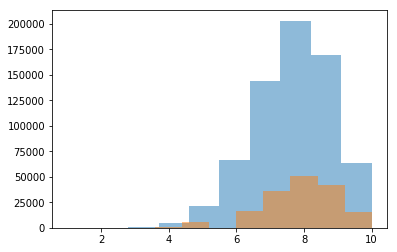

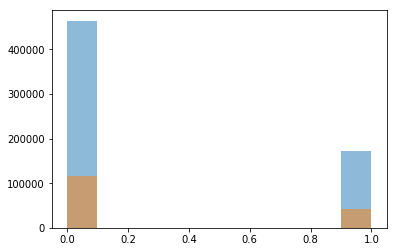

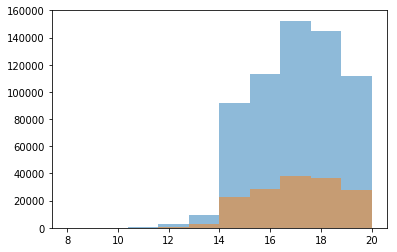

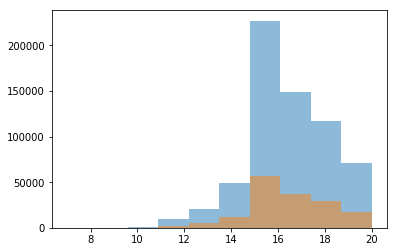

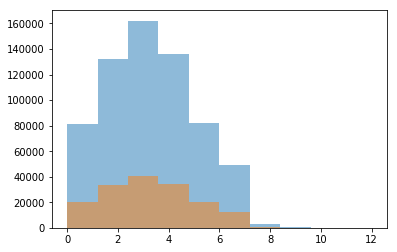

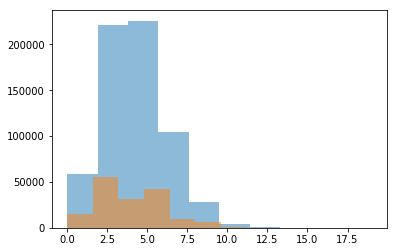

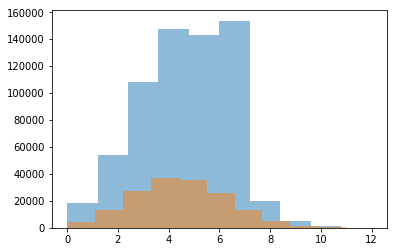

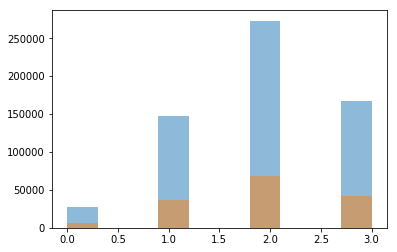

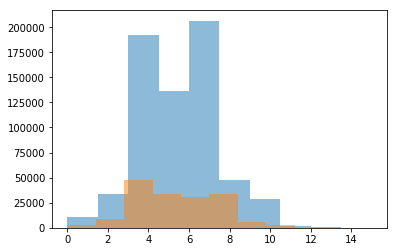

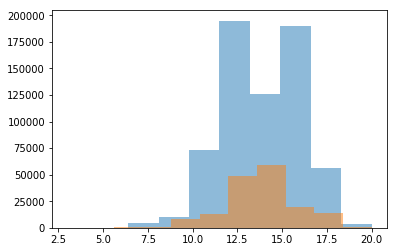

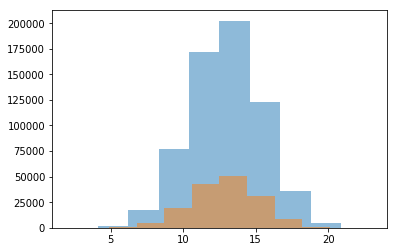

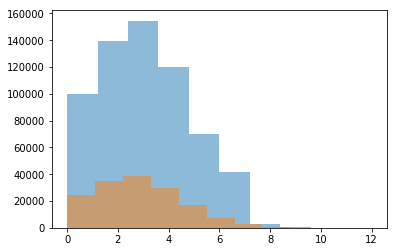

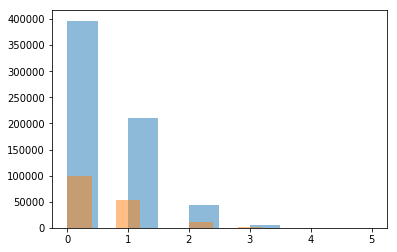

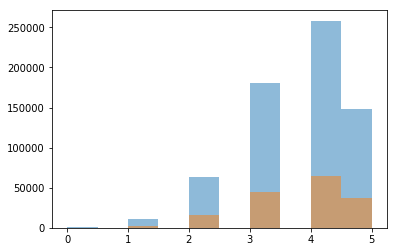

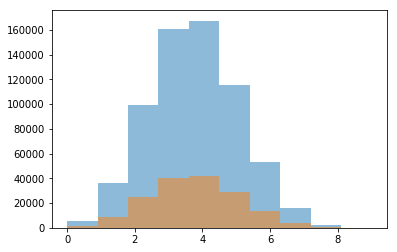

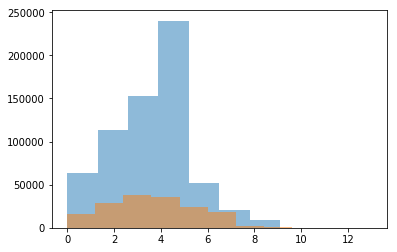

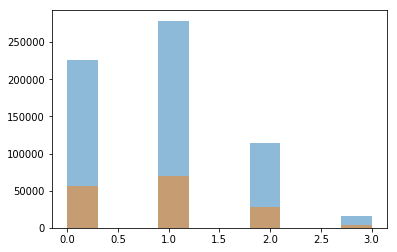

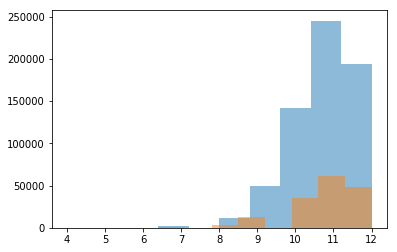

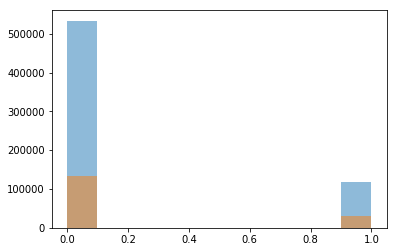

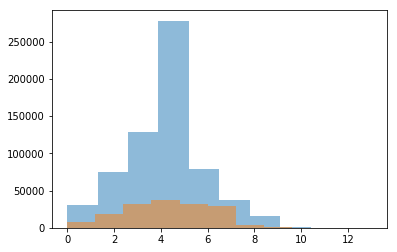

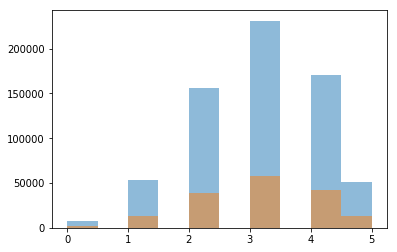

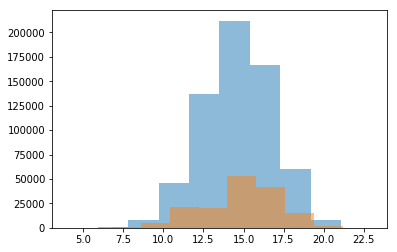

In [13]:
for i in columns_int_list:
    plt.hist(x_train_init.loc[:,i].dropna().astype("float").astype("int"), label = "train", alpha=0.5)
    plt.hist(x_test.loc[:,i].dropna().astype("float").astype("int"), label = 'test', alpha=0.5)
    plt.show()

Составим список int переменных, где 0 в составе уникальных значений

In [14]:
list_of_ints_with_zero_min = [i for i in columns_int_list if 0 in x_train_init.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").\
                                        value_counts().\
                                        index.tolist()]

Убедимся, что список правильный

In [15]:
for i in list_of_ints_with_zero_min:
    print(sorted(x_train_init.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").unique().tolist()))

[0, 1, 2, 3, 4]
[0, 1, 2, 3]
[0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 3]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3]
[0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
[0, 1, 2, 3, 4, 5]


Проверим обратный список - где значения не содержат 0 и проверим аналогичные значения в тестовой таблице. Они также не содержат 0.
Данные могут быть отфильтрованы с исключением 0 и других значений, мы можем отвергнуть наше допущение в последующих этапах анализа.

In [16]:
list_of_ints_without_zero_min = [i for i in columns_int_list if 0 not in x_train_init.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").\
                                        value_counts().\
                                        index.tolist()]

for i in list_of_ints_without_zero_min:
    print(sorted(x_train_init.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").unique().tolist()))
    print(sorted(x_test.loc[:,i].dropna().\
                                        astype("float").\
                                        astype("int").unique().tolist()))
    
    print("=======================================")

[7, 8, 9, 10, 11, 12, 13]
[7, 8, 9, 10, 11, 12, 13]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[17, 18, 19, 20, 21, 22, 23, 24]
[17, 18, 19, 20, 21, 22, 23, 24]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]
[4, 5, 6, 7, 8, 9, 10, 11, 12]
[5, 6, 7, 8, 9, 10, 11, 12]
[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


Список качественных переменных и количественных:

In [17]:
cat_vars = [i for i in x_train_init.columns if i in list_of_ints_with_zero_min]
num_vars = [i for i in x_train_init.columns if i not in list_of_ints_with_zero_min]

Прежде чем присвоить NaN значениям значение 999 мы разделим таблицу на тренировочную и валидационную чтобы производить все Imputation манипуляции в одном разделе. Т.к. 

In [18]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train_init, y_train_init, test_size=0.2, random_state=42,
                                                         stratify = y_train_init.values)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)

(576000, 58)
(576000, 1)
(144000, 58)
(144000, 1)
(180000, 58)


Конвертируем "Y" переменные в pd.Series и удостоверямся, что они были правильно стратифицированы при сплите.

In [20]:
# pd.DataFrame(y_train["y_train"].value_counts(), y_valid["y_train"].value_counts())
y_train = y_train["y_train"]
y_valid = y_valid["y_train"]
print(pd.concat([y_train.value_counts() / y_train.shape[0], 
                y_valid.value_counts() / y_valid.shape[0],
                y_train_init["y_train"].value_counts() / y_train_init.shape[0]], axis = 1))


    y_train   y_train   y_train
0  0.693267  0.693264  0.693267
1  0.306733  0.306736  0.306733


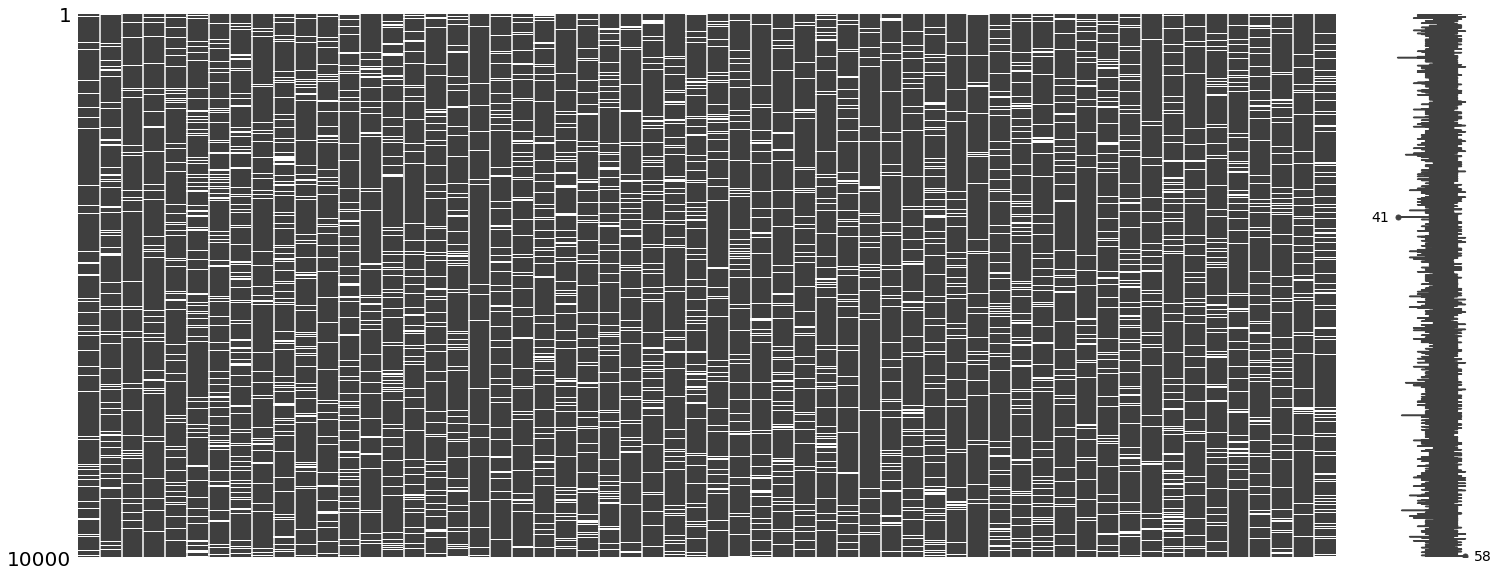

In [21]:
msno.matrix(x_train_init.sample(10000))

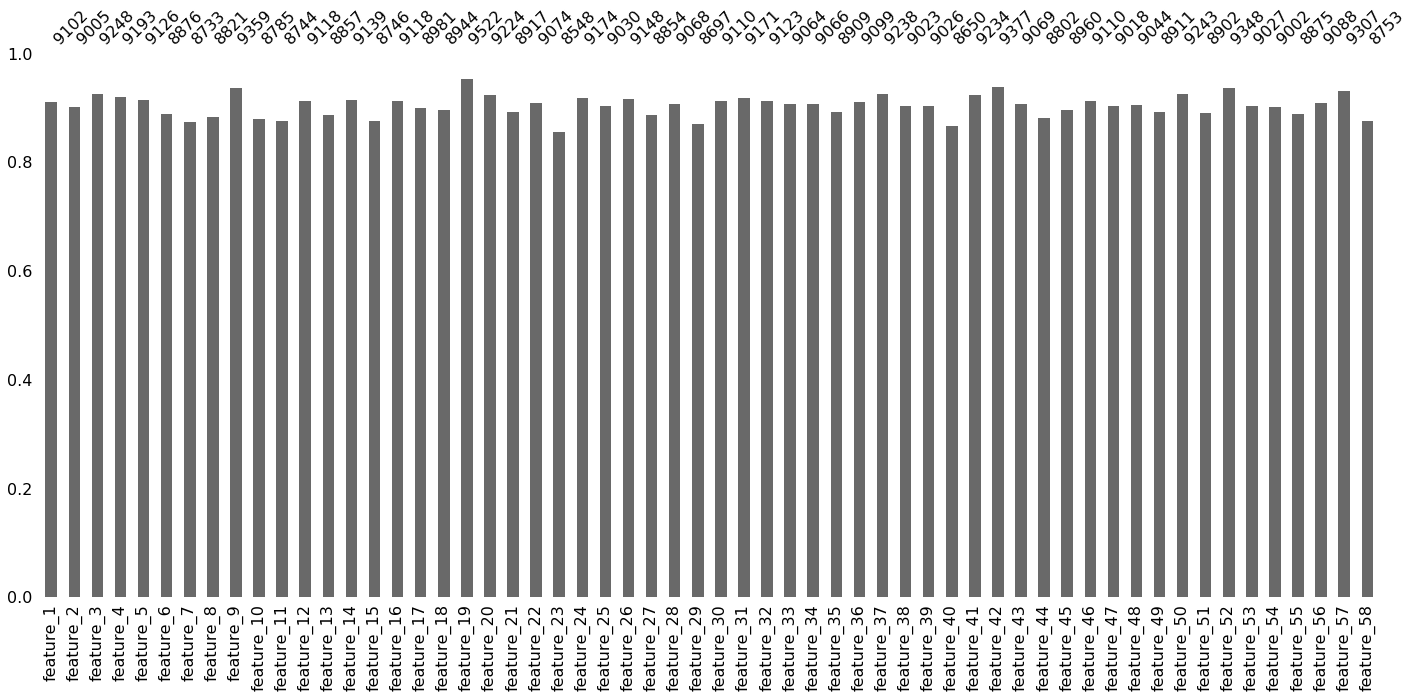

In [22]:
msno.bar(x_train_init.sample(10000))

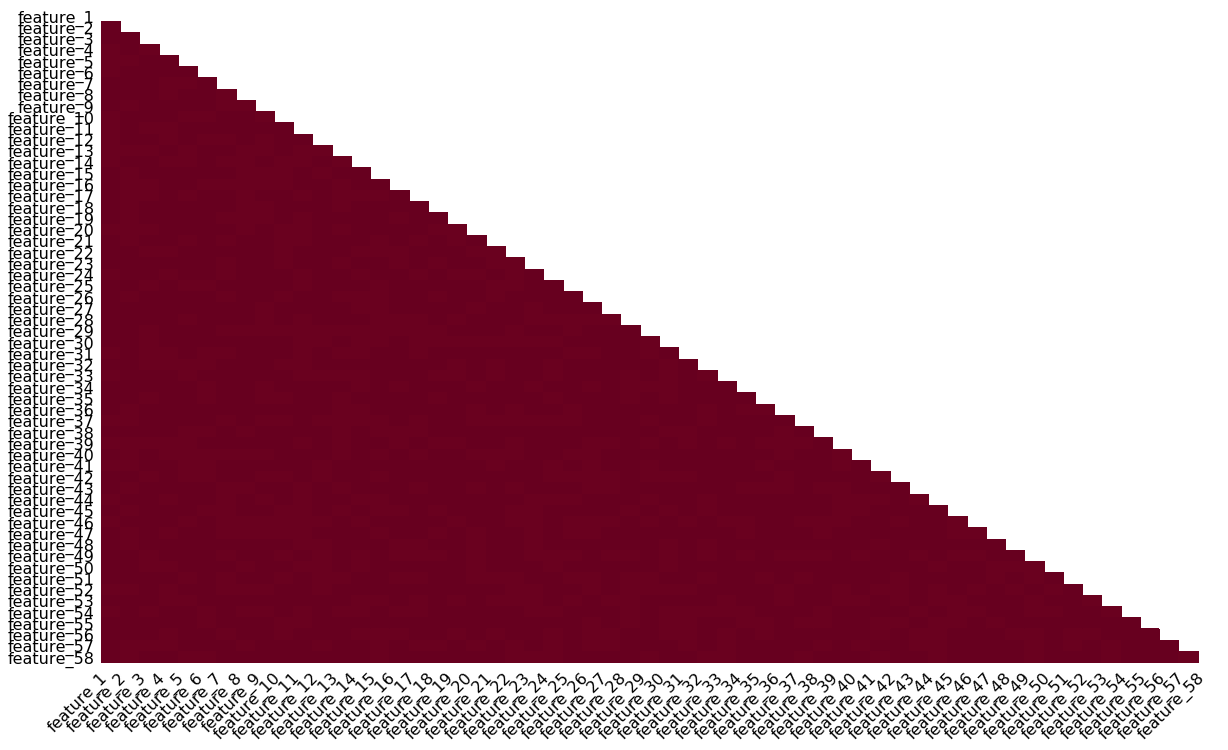

In [23]:
msno.heatmap(x_train_init)

Разделим все таблицы на количественные и качественные части для обработки (замена отсутствующих значений и стандартизация)

In [28]:
x_train_cat = x_train[cat_vars].fillna(999)
x_valid_cat = x_valid[cat_vars].fillna(999)
x_test_cat = x_test[cat_vars].fillna(999)

x_train_num = x_train[num_vars]
x_valid_num = x_valid[num_vars]
x_test_num = x_test[num_vars]

In [25]:
impute_num = SimpleImputer(strategy = "median")

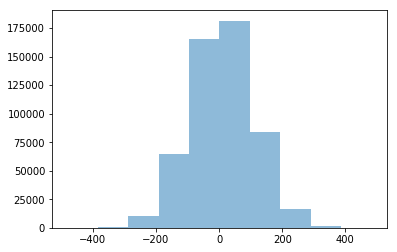

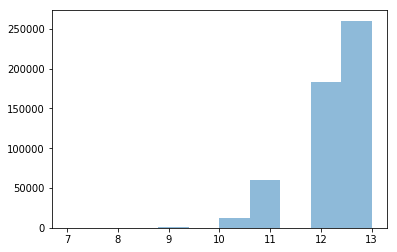

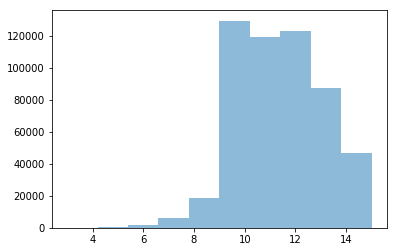

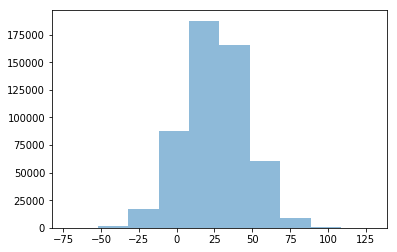

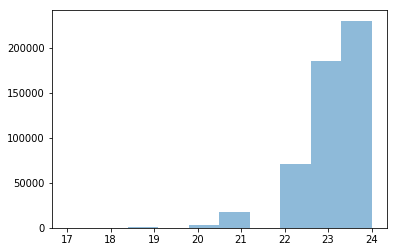

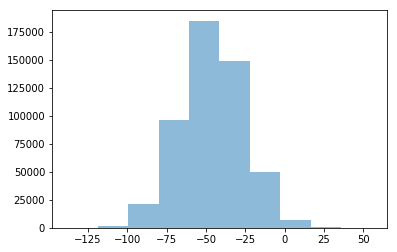

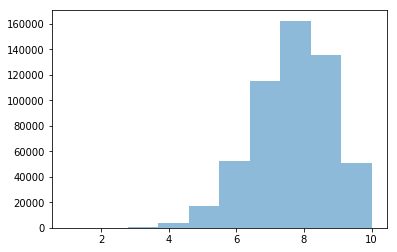

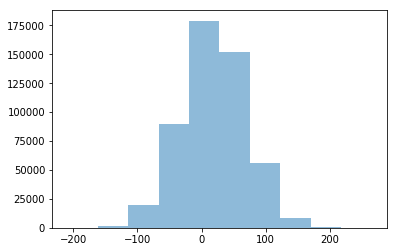

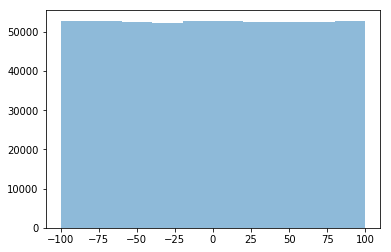

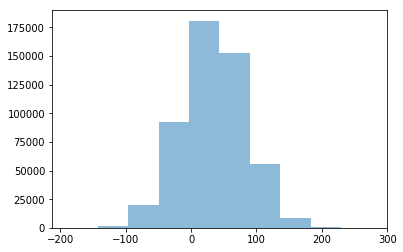

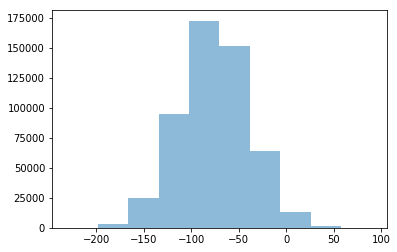

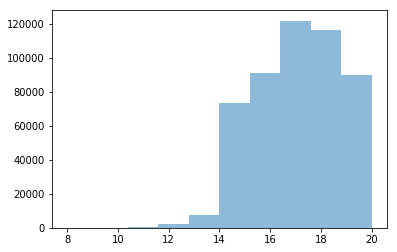

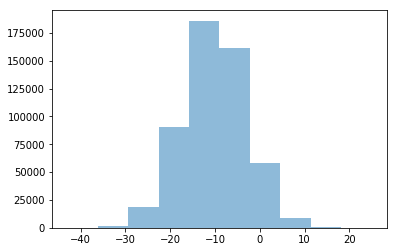

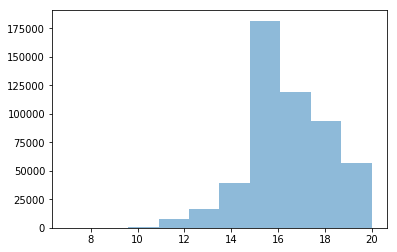

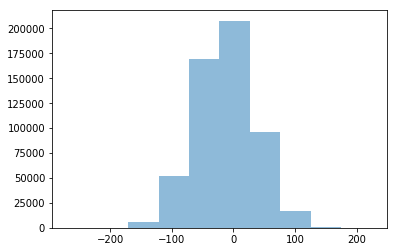

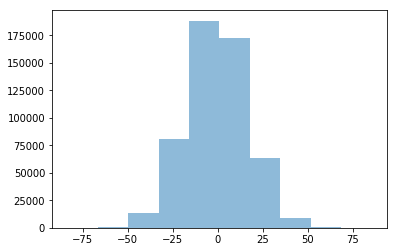

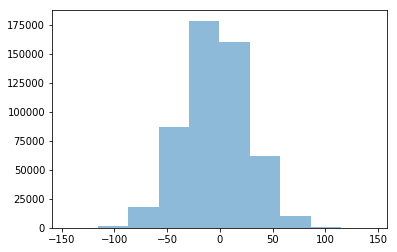

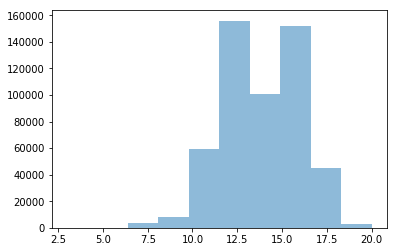

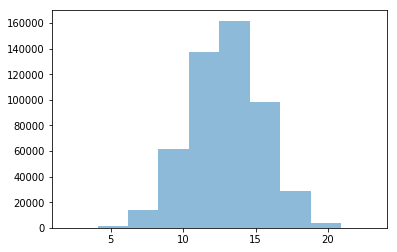

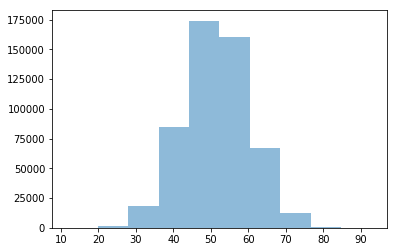

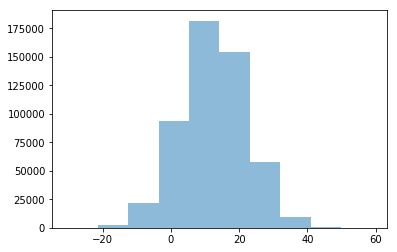

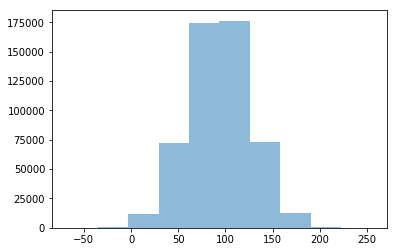

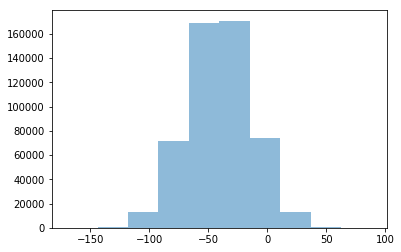

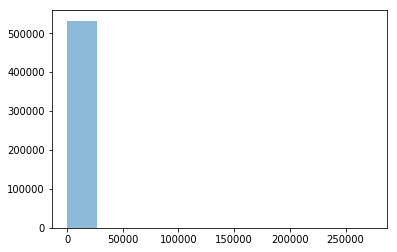

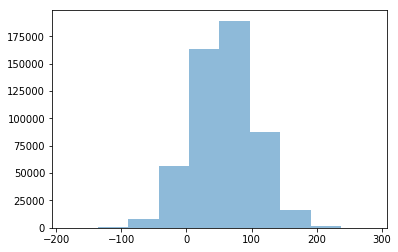

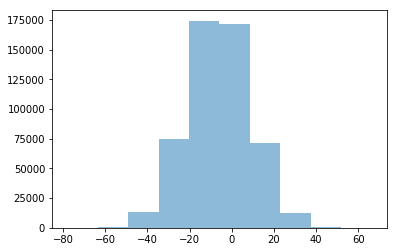

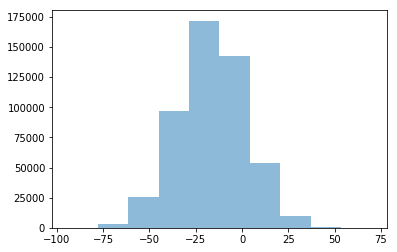

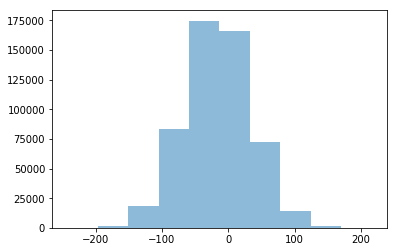

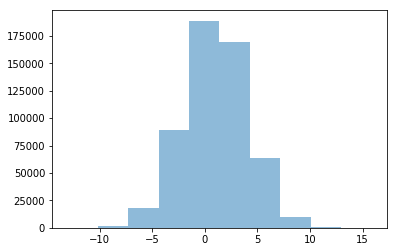

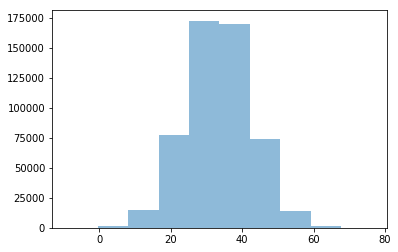

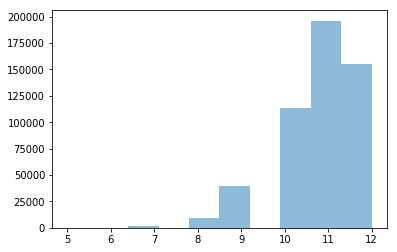

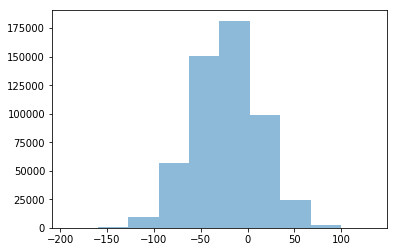

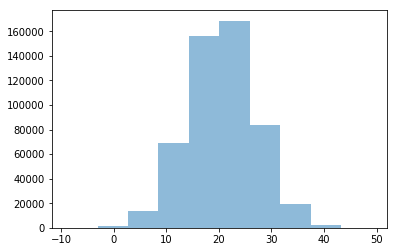

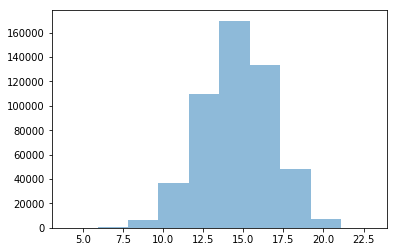

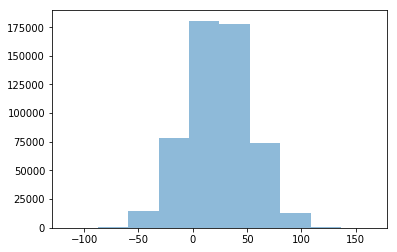

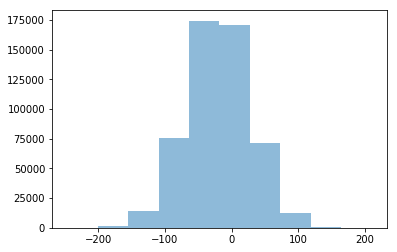

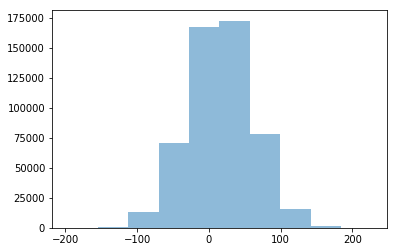

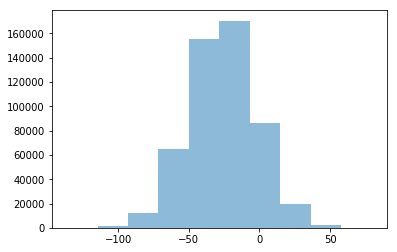

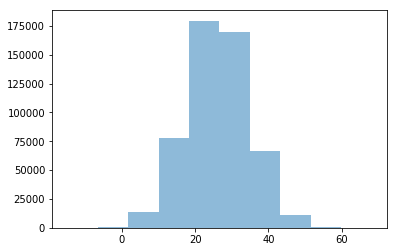

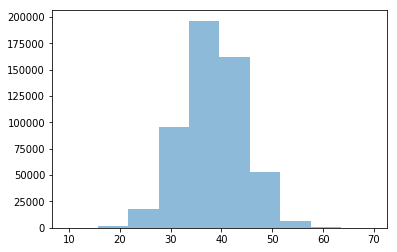

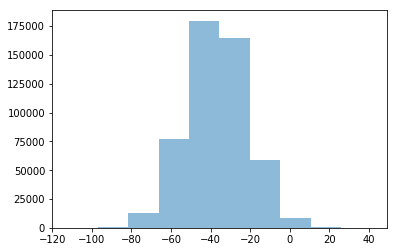

In [26]:
for i in num_vars:
    plt.hist(x_train_num.loc[:,i].dropna().astype("float"), alpha=0.5)
    plt.show()

In [29]:
x_train_num = impute_num.fit_transform(x_train_num)
x_valid_num = impute_num.transform(x_valid_num)
x_test_num = impute_num.transform(x_test_num)

Избавляемся от единиц наблюдения обычной стандартизацией со средним значением и стандартной девиацией

In [30]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_num_scaled = scaler.fit_transform(x_train_num)
x_valid_num_scaled = scaler.transform(x_valid_num)
x_test_num_scaled = scaler.transform(x_test_num)

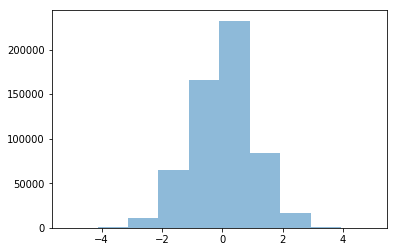

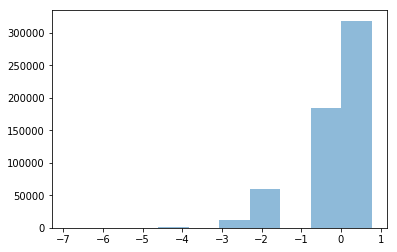

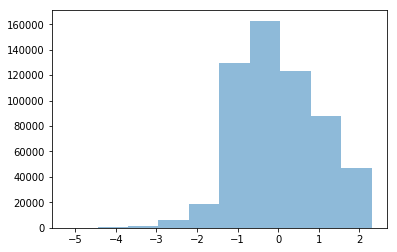

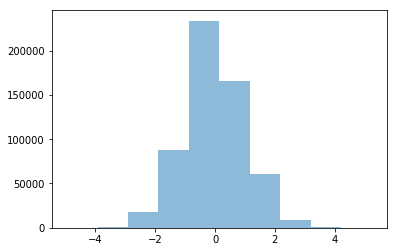

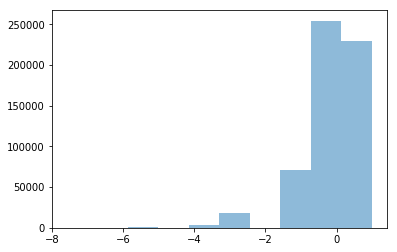

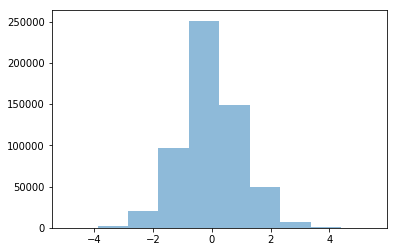

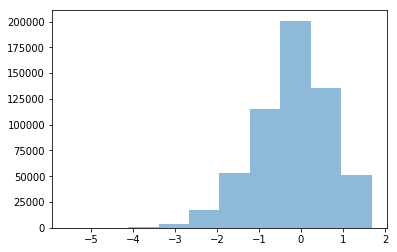

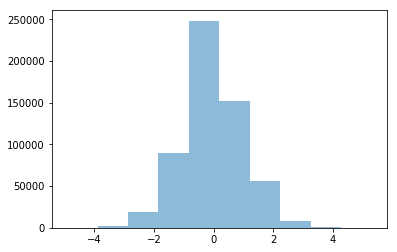

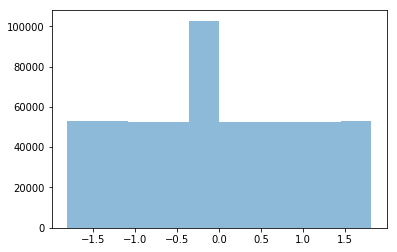

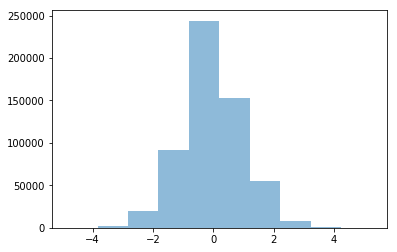

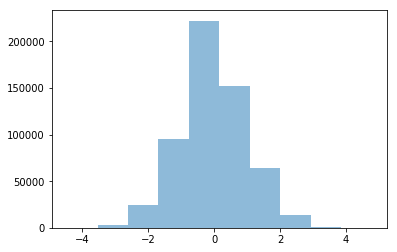

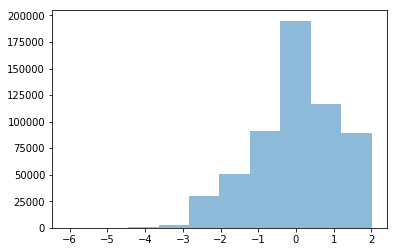

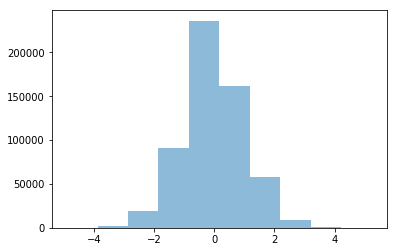

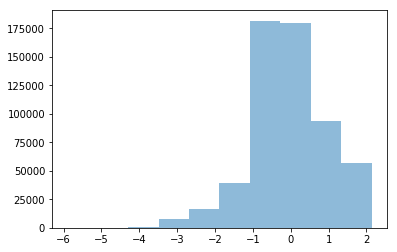

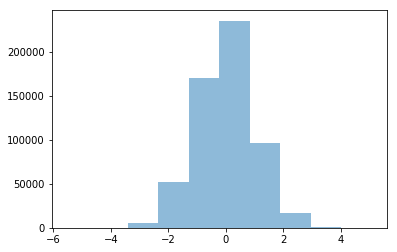

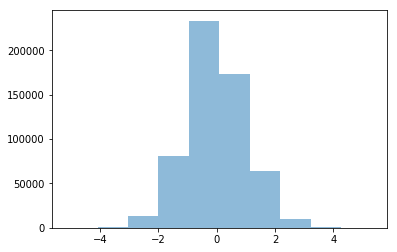

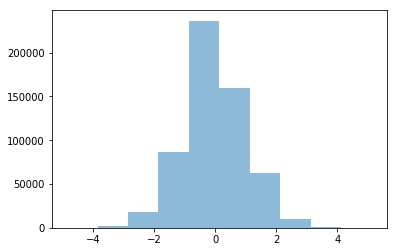

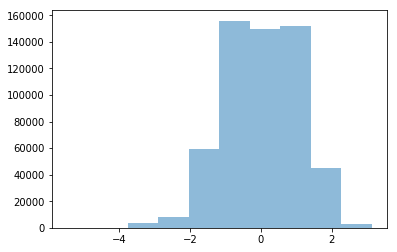

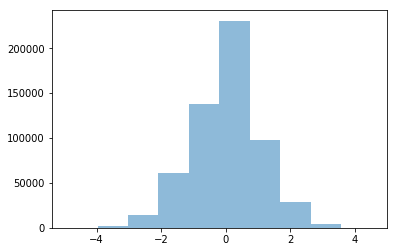

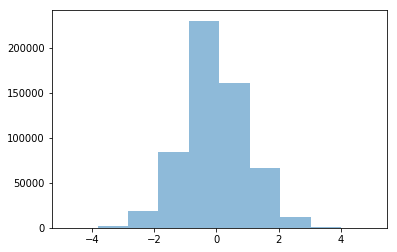

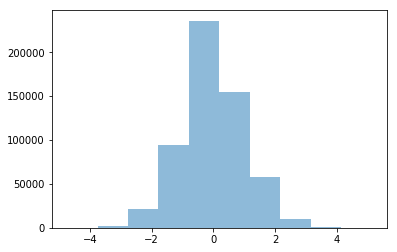

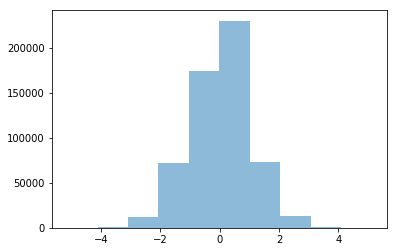

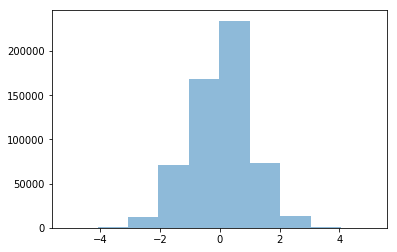

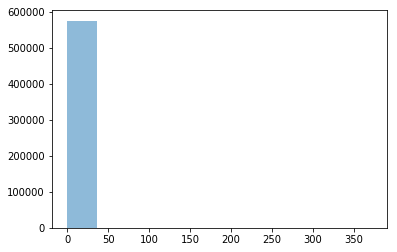

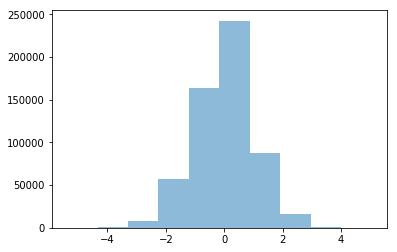

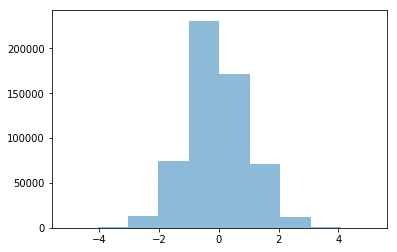

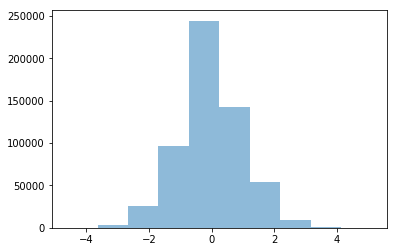

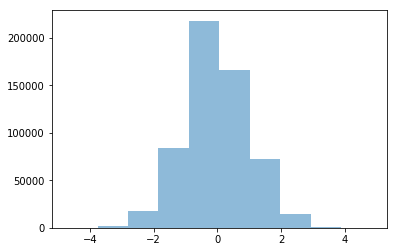

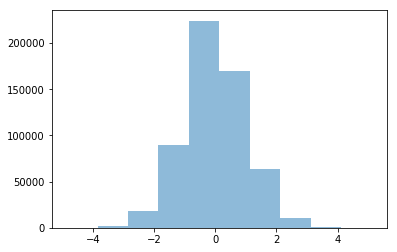

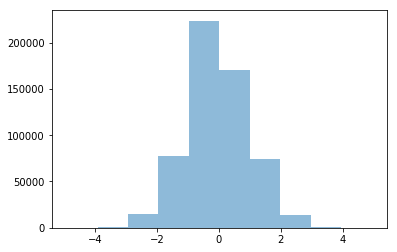

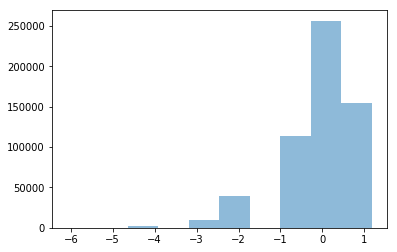

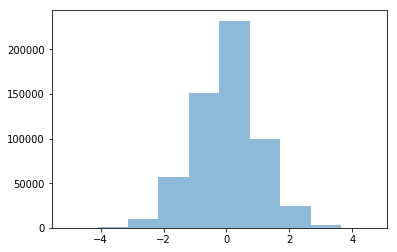

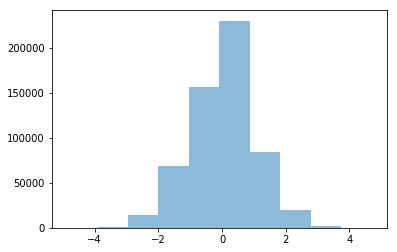

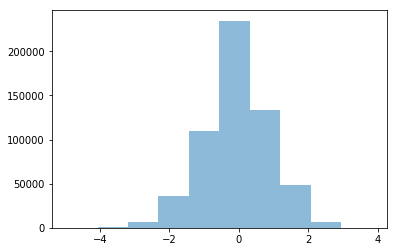

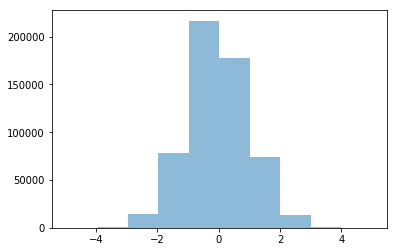

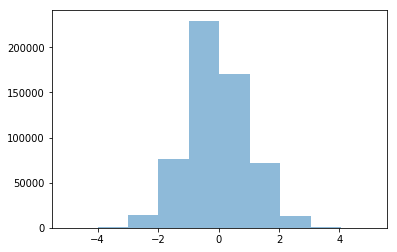

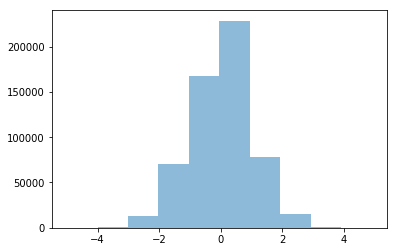

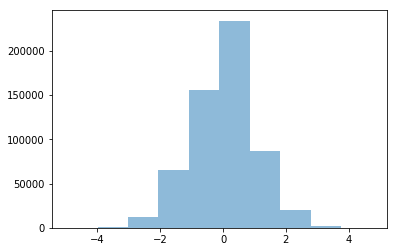

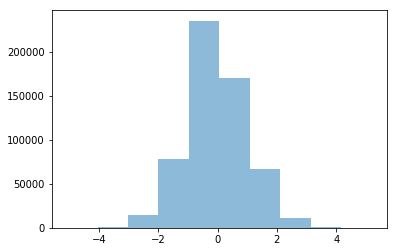

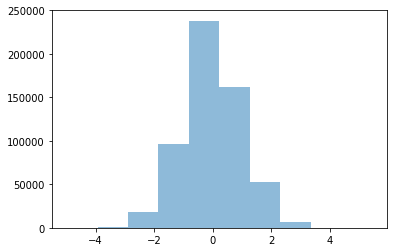

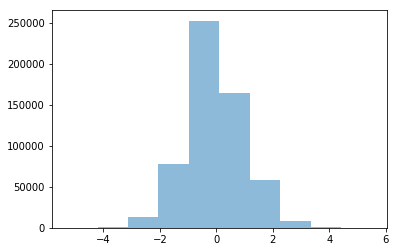

In [38]:
for i in pd.DataFrame(x_train_num_scaled).columns.tolist():
    plt.hist(pd.DataFrame(x_train_num_scaled).loc[:,i], alpha=0.5)
    plt.show()

In [43]:
x_train_cat = x_train_cat.astype("float").astype("int")
x_valid_cat = x_valid_cat.astype("float").astype("int")
x_test_cat = x_test_cat.astype("float").astype("int")

In [45]:
onehot_encoder = OneHotEncoder(handle_unknown = "ignore")
x_train_cat_onehot = onehot_encoder.fit_transform(x_train_cat)
x_valid_cat_onehot = onehot_encoder.transform(x_valid_cat)
x_test_cat_onehot = onehot_encoder.transform(x_test_cat)

In [65]:
final_x_train = np.hstack([x_train_num_scaled,
           x_train_cat_onehot.toarray()])

final_x_valid = np.hstack([x_valid_num_scaled,
           x_valid_cat_onehot.toarray()])

final_x_test = np.hstack([x_test_num_scaled,
           x_test_cat_onehot.toarray()])

In [64]:
svd_transformer = TruncatedSVD(n_components=80)
svd_transformer.fit(x_train_cat_onehot)
svd_transformer.explained_variance_ratio_.sum()

0.9553904883237337

In [ ]:
full_pipeline = Pipeline([
        # ('feature_selection', SelectKBest()),
        ('class', LogisticRegression()),
        ])
#
pg = {
    # 'feature_selection__k' : randint(1, 3),
    'class__penalty' : ["l1", "l2"],
    'class__C' : np.logspace(-10, -2, 500).tolist(),
    'class__fit_intercept' : [True, False],
    }

grid = RandomizedSearchCV(full_pipeline, param_distributions=pg,
                                        cv=5,
                                        scoring = "accuracy",
                                        verbose = 1,
                                        n_iter = 50,
                                        n_jobs = -1)

grid.fit(final_x_train, y_train.values.ravel())
df_grid = grid_scores_to_df(grid.grid_scores_).sort_values("score")
# df_grid

pd.DataFrame(grid.grid_scores_).sort_values("mean_validation_score")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
